### PyTorch官方參考範例
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import os
import glob
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
import time
from PIL import Image

def CCSN_images(dataset_dir):
    classfolder = glob.glob(os.path.join(dataset_dir,"*"),recursive=True)
    class_name  = [f.split(os.path.sep)[-1] for f in classfolder]
    img_labels  = []
    img_list    = []

    for class_id, f in enumerate(classfolder):
        files = glob.glob(os.path.join(f,"*.jpg"),recursive=True)
        img_labels.extend([class_id]*len(files))
        img_list.extend(files)

    img_labels = np.array(img_labels)
    img_list   = np.array(img_list,dtype=object)

    return img_list.reshape((-1,1)), img_labels, class_name

### 定義Dataset

In [2]:
class CCSNImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, img_labels, transform=None, target_transform=None):
        self.transform        = transform
        self.target_transform = target_transform
        self.img_list         = img_list
        self.img_labels       = img_labels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_list[idx,0]
        image    = Image.open(img_path)
        label    = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


### 設定CCSN資料集路徑
例如:
![image.png](attachment:image.png)

In [3]:


CCSNDataset_Path = "CCSN_v2"
img_list, img_labels, label_names = CCSN_images(CCSNDataset_Path)

CCSNDataset = CCSNImageDataset(img_list,img_labels)

### 範例:透過Dataset載入並顯示部分資料集

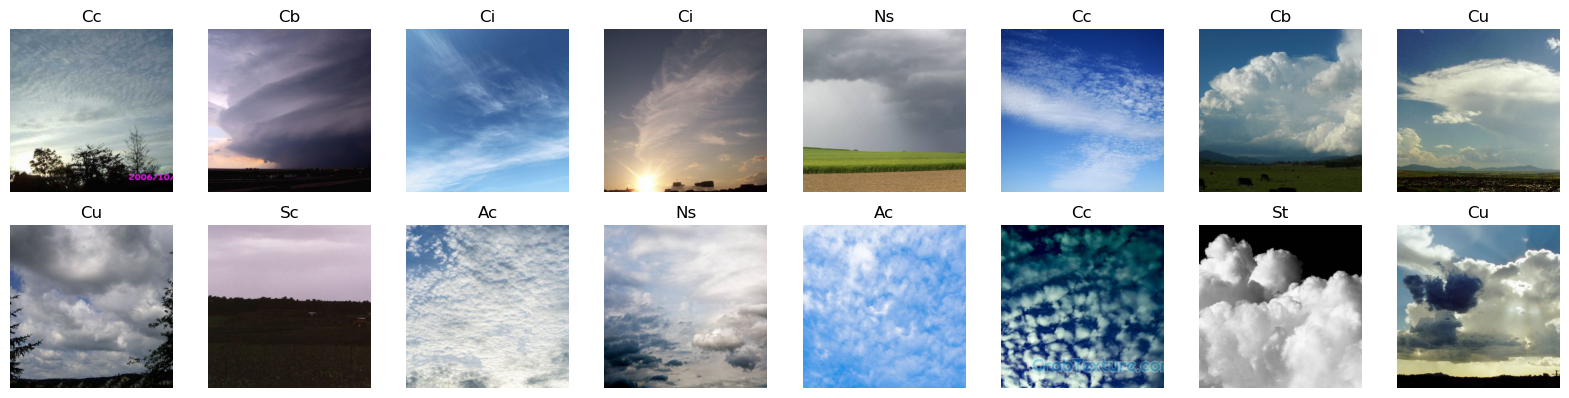

In [4]:
N = len(CCSNDataset)

plt.figure(figsize=(16,8))

for i in range(16):
    plt.subplot(4,8,i+1)
    image, label = CCSNDataset[np.random.randint(0,N)]
    plt.imshow(image)
    plt.title(label_names[label])
    plt.axis(False)
plt.tight_layout()
plt.show()

### 使用預訓練模型
列出torchvision.models裡內建預訓練模型。

In [5]:
import torchvision
dir(torchvision.models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [6]:
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25, patience = 0,scheduler = None):

    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = None
        best_acc  = 0
        history = {'loss':[],'accuracy':[],'val_loss':[],'val_accuracy':[]}
        patience_c = 0
        for epoch in range(num_epochs):
            print(f'Epoch {epoch:3d}/{num_epochs - 1}',end=' ')

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train' and scheduler:
                    scheduler.step(epoch_loss)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}',end=' ' if phase=='train' else '\n')
                if phase == 'train':
                    history['loss'].append(epoch_loss)
                    history['accuracy'].append(epoch_acc.cpu().numpy())

                # deep copy the model
                if phase == 'val':
                    history['val_loss'].append(epoch_loss)
                    history['val_accuracy'].append(epoch_acc.cpu().numpy())
                    if best_acc < epoch_acc.cpu().numpy():
                        best_acc = epoch_acc.cpu().numpy()
                    if epoch == 0 or epoch_loss < best_loss:
                        best_loss = epoch_loss
                        patience_c= 0
                        torch.save(model.state_dict(), best_model_params_path)
                    else:
                        patience_c += 1

            if patience_c > patience:
                break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, history

def evaluate(model, dataloader):

    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    dataset_size     = 0
        # Iterate over data.
    for inputs, labels in dataloader:

        dataset_size += inputs.size(0)

        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size

    print(f'test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return epoch_loss, epoch_acc.cpu().numpy()

In [7]:
def build_resnet(class_number,trainable=True):
    resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

    for param in resnet.parameters():
        param.requires_grad = trainable

    num_ftrs = resnet.fc.in_features
    # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
    resnet.fc = torch.nn.Linear(num_ftrs, class_number)

    return resnet

def build_efficientnet(class_number, trainable=True):
    model = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT)

    # Set trainability
    for param in model.parameters():
        param.requires_grad = trainable
    # Replace the classifier head
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, class_number)

    return model

def build_vit(class_number, trainable=True):
    model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)

    # Set trainability
    for param in model.parameters():
        param.requires_grad = trainable

    # Replace the head
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, class_number)

    return model

In [8]:
from sklearn.model_selection import StratifiedKFold

device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print('gpu is available')
else:
    print('cpu only')

data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.RandomRotation(40),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

skf        = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) # 80 % for training and validation sets, 20 % for the test set

batch_size = 64
epochs     = 100
patience   = epochs//5

test_accuracy = []
test_loss     = []
histories     = []

criterion = nn.CrossEntropyLoss()

for i, (train_idx, test_idx) in enumerate(skf.split(img_list,img_labels)):

    print('-'*50)

    X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(img_list[train_idx],img_labels[train_idx],test_size=0.2,random_state=i)

    testloader = torch.utils.data.DataLoader(CCSNImageDataset(img_list[test_idx],img_labels[test_idx],data_transforms['train'],lambda x : torch.tensor(x,dtype=torch.long)),batch_size=1,shuffle=True)
    trainloader= torch.utils.data.DataLoader(CCSNImageDataset(X_train,y_train,data_transforms['train'],lambda x : torch.tensor(x,dtype=torch.long)),batch_size=batch_size,shuffle=True)
    validloader= torch.utils.data.DataLoader(CCSNImageDataset(X_valid,y_valid,data_transforms['val'],lambda x : torch.tensor(x,dtype=torch.long)),batch_size=batch_size,shuffle=True)

    efficientNet = build_efficientnet(len(label_names),False)
    efficientNet = efficientNet.to(device)
    # Observe that all parameters are being optimized
    optimizer_ft = optim.Adam(efficientNet.classifier.parameters())

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.5, patience=3)

    trained_model, history = train_model(efficientNet, criterion, optimizer_ft,
                                         dataloaders={'train':trainloader,'val':validloader},
                                         dataset_sizes={'train':X_train.shape[0],'val':X_valid.shape[0]},
                                         patience=patience,
                                         num_epochs=epochs,
                                         scheduler = scheduler)

    histories.append(history)
    print(f'Fold {i+1:2d}',end=' ')
    loss, acc = evaluate(trained_model, testloader)

    test_loss.append(loss)
    test_accuracy.append(acc)

gpu is available
--------------------------------------------------
Epoch   0/99 train Loss: 2.2536 Acc: 0.2250 val Loss: 2.0510 Acc: 0.3292
Epoch   1/99 train Loss: 2.0521 Acc: 0.3178 val Loss: 1.8767 Acc: 0.3833
Epoch   2/99 train Loss: 1.9266 Acc: 0.3632 val Loss: 1.7919 Acc: 0.4029
Epoch   3/99 train Loss: 1.8661 Acc: 0.3712 val Loss: 1.7350 Acc: 0.4226
Epoch   4/99 train Loss: 1.8389 Acc: 0.3891 val Loss: 1.6954 Acc: 0.4128
Epoch   5/99 train Loss: 1.8012 Acc: 0.3983 val Loss: 1.6667 Acc: 0.4152
Epoch   6/99 train Loss: 1.7817 Acc: 0.3970 val Loss: 1.6571 Acc: 0.4324
Epoch   7/99 train Loss: 1.7472 Acc: 0.4136 val Loss: 1.6452 Acc: 0.4373
Epoch   8/99 train Loss: 1.7475 Acc: 0.4149 val Loss: 1.6263 Acc: 0.4324
Epoch   9/99 train Loss: 1.7410 Acc: 0.4247 val Loss: 1.6179 Acc: 0.4496
Epoch  10/99 train Loss: 1.6979 Acc: 0.4130 val Loss: 1.6204 Acc: 0.4275
Epoch  11/99 train Loss: 1.6926 Acc: 0.4216 val Loss: 1.6176 Acc: 0.4423
Epoch  12/99 train Loss: 1.6895 Acc: 0.4222 val Loss: 1.

/tmp/ipykernel_1578/1696249048.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


test Loss: 1.7371 Acc: 0.3969
--------------------------------------------------
Epoch   0/99 train Loss: 2.2922 Acc: 0.1942 val Loss: 2.0563 Acc: 0.3489
Epoch   1/99 train Loss: 2.0587 Acc: 0.3245 val Loss: 1.8599 Acc: 0.4251
Epoch   2/99 train Loss: 1.9577 Acc: 0.3417 val Loss: 1.7930 Acc: 0.4349
Epoch   3/99 train Loss: 1.8659 Acc: 0.3786 val Loss: 1.7427 Acc: 0.4324
Epoch   4/99 train Loss: 1.8345 Acc: 0.3792 val Loss: 1.7248 Acc: 0.4373
Epoch   5/99 train Loss: 1.8181 Acc: 0.3921 val Loss: 1.7098 Acc: 0.4423
Epoch   6/99 train Loss: 1.7950 Acc: 0.3860 val Loss: 1.6788 Acc: 0.4398
Epoch   7/99 train Loss: 1.7380 Acc: 0.4026 val Loss: 1.6621 Acc: 0.4619
Epoch   8/99 train Loss: 1.7358 Acc: 0.4241 val Loss: 1.6729 Acc: 0.4496
Epoch   9/99 train Loss: 1.7224 Acc: 0.4100 val Loss: 1.6694 Acc: 0.4349
Epoch  10/99 train Loss: 1.6907 Acc: 0.4253 val Loss: 1.6496 Acc: 0.4570
Epoch  11/99 train Loss: 1.6892 Acc: 0.4210 val Loss: 1.6513 Acc: 0.4496
Epoch  12/99 train Loss: 1.6528 Acc: 0.4345

In [9]:
print(efficientNet)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 顯示結果

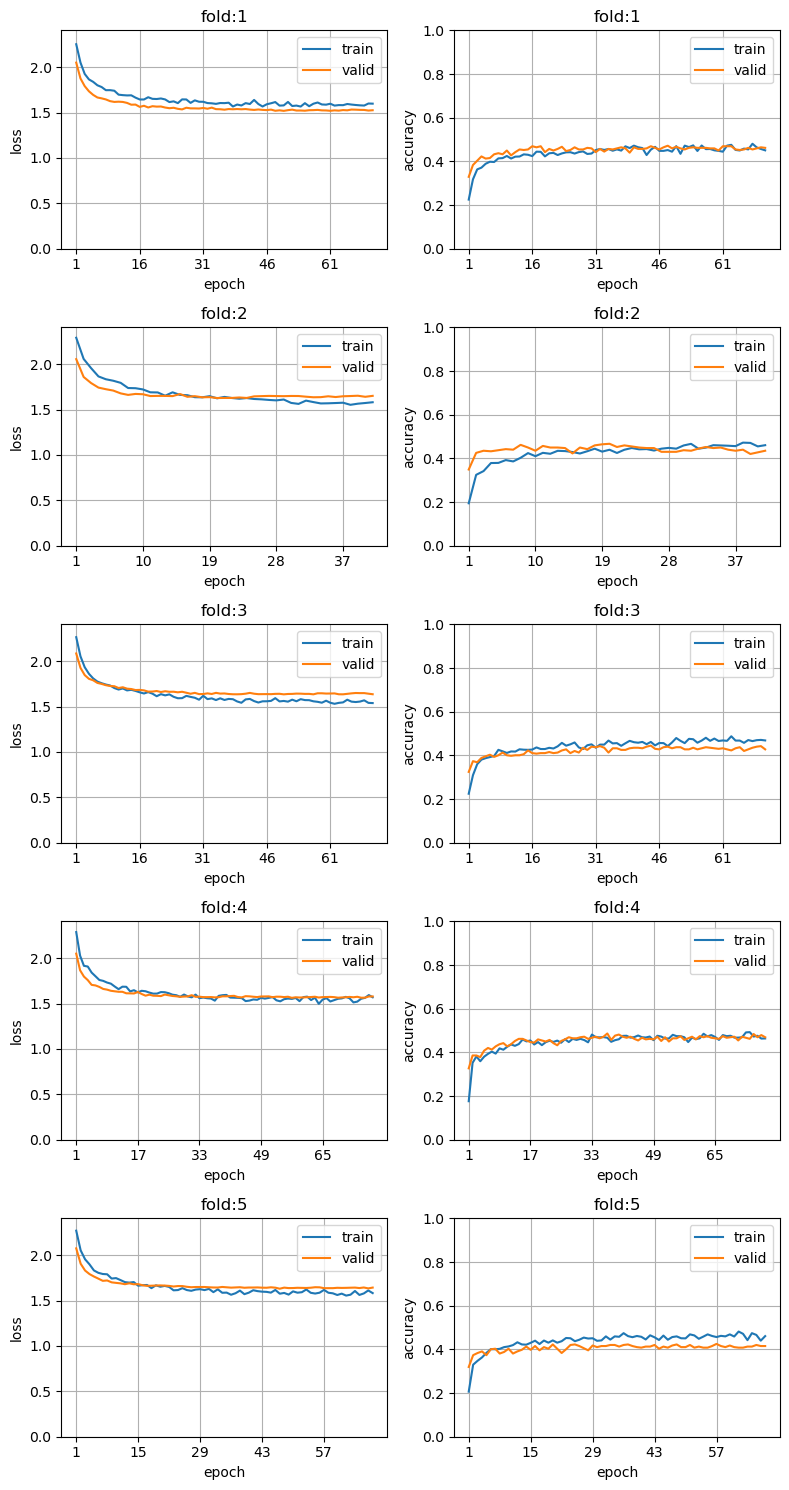

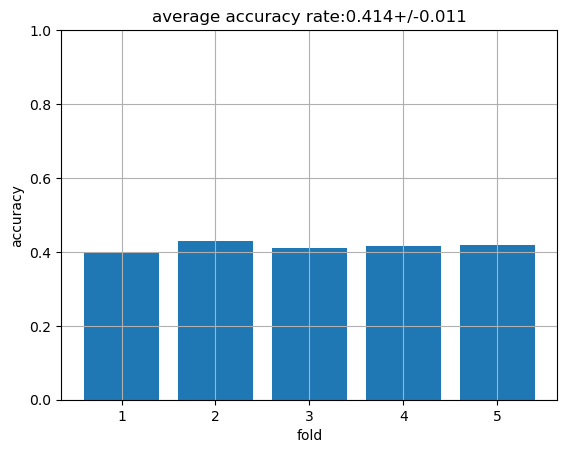

average accuracy rate:0.414+/-0.011


In [10]:
plt.figure(figsize=(8,3*len(histories)))

max_loss = 0
max_acc  = 0
for i,history in enumerate(histories):
    max_loss = max(max_loss,np.max(history['loss']),np.max(history['val_loss']))

max_loss *= 1.05
for i,history in enumerate(histories):
    plt.subplot(len(histories),2,i*2+1)
    plt.title(f'fold:{i+1}')
    plt.plot(history['loss'],label='train')
    plt.plot(history['val_loss'],label='valid')
    plt.xlabel('epoch')
    step = int(np.ceil(len(history['loss'])/5))
    plt.xticks(np.arange(0,len(history['loss']),step),[str(u+1) for u in np.arange(0,len(history['loss']),step)])
    plt.ylabel('loss')
    plt.ylim([0,max_loss])
    plt.grid(True)
    plt.legend()

    plt.subplot(len(histories),2,i*2+2)
    plt.title(f'fold:{i+1}')
    plt.plot(history['accuracy'],label='train')
    plt.plot(history['val_accuracy'],label='valid')
    plt.xticks(np.arange(0,len(history['accuracy']),step),[str(u+1) for u in np.arange(0,len(history['accuracy']),step)])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.ylim([0,1.0])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

plt.figure()
plt.bar(x=np.arange(len(test_accuracy)),height=np.array(test_accuracy))
plt.xlabel('fold')
plt.xticks(np.arange(len(test_accuracy)),[str(i+1) for i in np.arange(len(test_accuracy))])
plt.ylabel('accuracy')
plt.title(f'average accuracy rate:{np.mean(np.array(test_accuracy)):.3f}+/-{np.std(np.array(test_accuracy)):.3f}')
plt.grid(True)
plt.ylim([0,1.0])
plt.show()
print(f'average accuracy rate:{np.mean(np.array(test_accuracy)):.3f}+/-{np.std(np.array(test_accuracy)):.3f}')